<a href="https://colab.research.google.com/github/Syed-MuhammadTaha/AdvTensorFlowPractice/blob/main/AdvanceTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Course 1: Custom Model, Layers, Callbacks and Loss function

### **Functional API with multiple inputs (Siamese Network)**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def base_network():
  input = keras.Input(shape=(28,28,))
  x = layers.Flatten()(input)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(128, activation='relu')(x)
  return keras.Model(inputs=input, outputs=x)

In [ ]:
base = base_network()
base.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,504 (521.50 KB)

 Trainable params: 133,504 (521.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
input_1 = keras.Input(shape=(28,28,))
input_2 = keras.Input(shape=(28,28,))

vec_a = base(input_1)
vec_b = base(input_2)



In [ ]:
def euclidean_distance(vectors):
  x,y = vectors
  sum_square = tf.math.reduce_sum(tf.math.square(x-y), axis=1, keepdims=True)
  return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def euclidean_shape(shape):
  shape_a, shape_b = shape
  return (shape_a[0], 1)

In [ ]:
output = layers.Lambda(euclidean_distance, output_shape=euclidean_shape)([vec_a, vec_b])

In [ ]:
model = keras.Model(inputs=[input_1, input_2], outputs=output)

In [ ]:
# contrastive loss is similar to the triplet loss but a supervised form where pairs of image are labelled 1 or 0 based on their similarity
model.compile(loss=contrastive_loss_w_margin(margin=1), optimizer="adam", metrics=["accuracy"])

### **Custom Loss**

In [ ]:
# contrastive fromula: Y * D^2 + (1-Y) * max(alpha - D, 0)
# Triplet loss: max(euc_dist(A,P) - euc_dist(A,N) + alpha)
def contrastive_loss(y_true, y_pred):
  margin = 1
  square_pred = tf.math.square(y_pred)
  margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
  return ((y_true * square_pred) + (1 - y_true) * margin_square)

In [ ]:
# with hyperparameter
def contrastive_loss_w_margin(margin):
  def contrastive_loss(y_true, y_pred):
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
    return ((y_true * square_pred) + (1 - y_true) * margin_square)
  return contrastive_loss

### **Custom Layers**

Lambda Layers

In [ ]:
def custom_relu(x):
  return tf.math.maximum(0.0, x)

In [ ]:
model = keras.Sequential([
    layers.Flatten(input_shape=(28,28)),
    layers.Lambda(custom_relu),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
])

Custom Layer Class

Made up of *state* (weights) and *computation* (forward pass)

In [ ]:
class SimpleDense(layers.Layer):
  # calling layer counstructor inherited by layers.Layer class which already has w and b instance variables
  # adding units and activation instance variables to the constructor
  def __init__(self, units=32, activation=None):
    super(SimpleDense, self).__init__()
    self.units = units
    self.activation = tf.keras.activations.get(activation)
  # all the code for setting w and b tensors
  def build(self, input):
    w_init = tf.keras.initializers.GlorotNormal()
    b_init = tf.zeros_initializer()
    self.w = tf.Variable(name="kernel", initial_value = w_init(shape=(input.shape[-1], self.units), dtype="float32"), trainable=True)
    self.b = tf.Variable(name="bias", initial_value = b_init(shape=(self.units,), dtype="float32"), trainable=True)

  # computation during forward pass
  def call(self, input):
    return self.activation(tf.matmul(input, self.w) + self.b)

### **Custom Models**

In [ ]:
class WideandDeepModel(keras.Model):
  def __init__(self, units=30, activation="relu", **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = layers.Dense(units, activation=activation)
    self.hidden2 = layers.Dense(units, activation=activation)
    self.main_output = layers.Dense(1)
    self.aux_output = layers.Dense(1)
  def call(self, inputs):
    input_A, input_B = inputs
    hidden1 = self.hidden1(input_B)
    hidden2 = self.hidden2(hidden1)
    concat = keras.layers.concatenate([input_A, hidden2])
    main_output = self.main_output(concat)
    aux_output = self.aux_output(hidden2)
    return main_output, aux_output

### **Custom Callbacks**

In [ ]:
class EarlyStopping(keras.callback.CallBack):
  def __init__(self, patience=0):
    super(EarlyStopping, self).__init__()
    self.patience = patience
  def on_epoch_end(self, epoch, logs=None):
    if logs.get("accuracy") > 0.99:
      print("Reached 99% accuracy so cancelling training!")
      self.model.stop_training = True

# Course 2: Custom and Distributed training

### **Tensors**

In [5]:
# mode.variables can be used to to check all the models variabls. We can note that it has kernel and bias
model = tf.keras.Sequential([keras.layers.Dense(1, input_shape=[1])])
model.variables

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[<KerasVariable shape=(1, 1), dtype=float32, path=sequential/dense/kernel>,
 <KerasVariable shape=(1,), dtype=float32, path=sequential/dense/bias>]

In [6]:
# cannot reshape variables during definition but tf.Constant can
tf.Variable([10,1,2,3], shape=(2,2), dtype=tf.float32)

ValueError: In this `tf.Variable` creation, the initial value's shape ((4,)) is not compatible with the explicitly supplied `shape` argument ((2, 2)).

### **Gradient Tape**

In [7]:
x_train = np.array([-1,0,1,2,3,4,5,6,7,8,9], dtype = float)
y_train = np.array([-3,-1,1,3,5,7,9,11,13,15,17], dtype = float)

w= tf.Variable(0.0, trainable=True)
b= tf.Variable(0.0, trainable=True)

In [ ]:
def loss(y_true, y_pred):
  return tf.reduce_mean(tf.square(y_true - y_pred))

learning_rate = 0.01

In [9]:
# persistent=true doesnot dispose off the gradients afte one calculation of gradients
def train_data(real_x, real_y):
  with tf.GradientTape(persistent=True) as t:
    y_pred = w * real_x + b
    current_loss = loss(real_y, y_pred)
  dw, db = t.gradient(current_loss, [w,b])
  w.assign_sub(learning_rate * dw)
  b.assign_sub(learning_rate * db)

In [10]:
for epoch in range(500):
  train_data(x_train, y_train)

In [11]:
print(w)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.995391>


### **Custom Training Loops**

In [13]:
import tensorflow_datasets as tfds

In [12]:
# define the base model
def base_model():
  inputs = keras.Input(shape=(784, ), name="clothing")
  x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
  x = layers.Dense(64, activation="relu", name="dense_2")(x)
  outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
  model = keras.Model(inputs=inputs, outputs=outputs)
  return model

In [15]:
# use tfds dataset to create dataset.Data API
train_dataset= tfds.load("fashion_mnist", split="train")
test_dataset = tfds.load("fashion_mnist", split="test")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.N8R9GE_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.N8R9GE_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [17]:
# define the pre-process function which will be used by .map function of the Data API
def preprocess(data):
  x = data["image"]
  y = data["label"]
  x = tf.reshape(x, [-1])
  x = tf.cast(x, tf.float32)
  x /= 255.0
  return x, y

In [18]:
# using shuffle, prefetch, repeat and batch functions from Data API
batch_size = 64
train_data = train_dataset.map(preprocess)
test_data = test_dataset.map(preprocess)
train_data = train_data.shuffle(buffer_size=1024).batch(batch_size)
test_data = test_data.batch(batch_size)

In [19]:
# specifying loss and cost functions
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [22]:
# train and test accuracy
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [20]:
model= base_model()

In [24]:
# defining custom loop for each epoch
def train_data_for_one_epoch():
  # noting loss for each batch
  losses = []
  # iterating through all batches: pair (x_batch, y_batch) stores info of all entries in a single batch on each iter, while step is the sample number in each batch
  for step, (x_batch, y_batch) in enumerate(train_data):
    with tf.GradientTape() as tape:
      # computing softmax outpu of the whole batch
      logits = model(x_batch)
      # computing batch loss
      loss_value = loss(y_batch, logits)
    # computing gradients during backprop
    grads = tape.gradient(loss_value, model.trainable_weights)
    # applying adam optimization to the gradints
    # If grads = [grad_W1, grad_W2] and model.trainable_weights = [W1, W2], then zip(grads, model.trainable_weights) will pair them like [(grad_W1, W1), (grad_W2, W2)].
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    losses.append(loss_value)
    train_acc_metric(y_batch, logits)
    if step % 100 == 0:
      print("Loss at step %d: %.4f" % (step, float(loss_value)))
  return losses

In [25]:
def perform_validation():
  losses = []
  for x_val, y_val in test_data:
    val_logits = model(x_val)
    val_loss = loss(y_val, val_logits)
    losses.append(val_loss)
    test_acc_metric(y_val, val_logits)
  print("Validation Loss: %.4f" % float(tf.reduce_mean(losses)))
  return losses

In [29]:

epochs = 20
epoch_train_losses = []
epoch_val_losses = []
for epoch in range(epochs):
  losses_train = train_data_for_one_epoch()
  train_acc = train_acc_metric.result()
  print("Training acc over epoch: %.4f" % float(train_acc))
  losses_val = perform_validation()
  test_acc = test_acc_metric.result()
  print("Testing acc over epoch: %.4f" % float(test_acc))

  loss_train_mean = tf.reduce_mean(losses_train)
  loss_val_mean = tf.reduce_mean(losses_val)

  epoch_train_losses.append(loss_train_mean)
  epoch_val_losses.append(loss_val_mean)
  train_acc_metric.reset_state()
  test_acc_metric.reset_state()



Loss at step 0: 0.0891
Loss at step 100: 0.1395
Loss at step 200: 0.1790
Loss at step 300: 0.1743
Loss at step 400: 0.2322
Loss at step 500: 0.2787
Loss at step 600: 0.2560
Loss at step 700: 0.1485
Loss at step 800: 0.1130
Loss at step 900: 0.1226
Training acc over epoch: 0.9065
Validation Loss: 0.3990
Testing acc over epoch: 0.8775
Loss at step 0: 0.2336
Loss at step 100: 0.1428
Loss at step 200: 0.3257
Loss at step 300: 0.2468
Loss at step 400: 0.1035
Loss at step 500: 0.1066
Loss at step 600: 0.1222
Loss at step 700: 0.0910
Loss at step 800: 0.1898
Loss at step 900: 0.2419
Training acc over epoch: 0.9351
Validation Loss: 0.4183
Testing acc over epoch: 0.8775
Loss at step 0: 0.1278
Loss at step 100: 0.3021
Loss at step 200: 0.0575
Loss at step 300: 0.1209
Loss at step 400: 0.1129
Loss at step 500: 0.1559
Loss at step 600: 0.2026
Loss at step 700: 0.0699
Loss at step 800: 0.0449
Loss at step 900: 0.1113
Training acc over epoch: 0.9367
Validation Loss: 0.3925
Testing acc over epoch: 0.

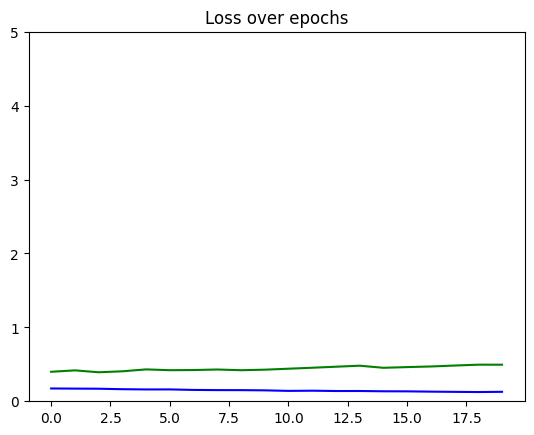

In [33]:
def plot_metric(train_metric, val_metric, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(train_metric, color='blue', label=metric_name)
  plt.plot(val_metric, color='green', label='val_' + metric_name)
  plt.show()

plot_metric(epoch_train_losses, epoch_val_losses,"Loss", "Loss over epochs")

### **Distributed Training**

In [34]:
# just have to enclose strategy's scope eithin our model and define batch size per replica(gpu)
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

Number of devices: 1


In [ ]:
with strategy.scope():
  model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=[1])])
model.compile(loss="mse", optimizer="sgd")

Other Strategies are too complicated to understand. Will code when required
